# Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ovm.monetary.model import MonetaryModel

import logging
import os
import random
import typing as tp

import line_profiler
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook
# %matplotlib widget
from mesa.datacollection import DataCollector
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import ChartModule
import numpy as np
import pandas as pd
import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
from tqdm import tqdm

from ovm.monetary.agents import (
    MonetaryAgent, 
    MonetaryArbitrageur, 
    MonetaryKeeper, 
    MonetaryLiquidator, 
    MonetarySniper
)

from ovm.monetary.markets import MonetaryFMarket
from ovm.monetary.model import MonetaryModel
from ovm.monetary.data_collection import DataCollectionOptions
from ovm.monetary.plot_labels import (
    price_deviation_label,
    spot_price_label,
    futures_price_label,
    skew_label,
    inventory_wealth_ovl_label,
    inventory_wealth_usd_label,
    GINI_LABEL,
    GINI_ARBITRAGEURS_LABEL,
    SUPPLY_LABEL,
    TREASURY_LABEL,
    LIQUIDITY_LABEL, 
)

from ovm.monetary.plots import (
    DEFAULT_FIGURE_SIZE, 
    convert_time_in_seconds_to_index, 
    convert_time_interval_in_seconds_to_indices, 
    construct_full_time_axis, 
    construct_time_axis, 
    get_indices_and_time_axis_to_plot, 
    plot_multiple_variables_over_time, 
    plot_price_deviations, 
    plot_skews, 
    plot_single_variable_over_time, 
    plot_single_variable_over_time_from_numpy_array, 
    plot_supply, 
    plot_treasury, 
    plot_liquidity, 
    plot_spot_vs_futures_price, 
    plot_open_positions
)

from ovm.monetary.reporters import * 
from ovm.monetary.data_io import (
    construct_sims_map, 
    construct_ticker_to_series_of_prices_map_from_simulated_prices, 
    construct_ticker_to_series_of_prices_map_from_historical_prices, 
    load_and_construct_ticker_to_series_of_prices_map_from_historical_prices,
    construct_hist_map
)

from ovm.paths import (
    HistoricalDataSource, 
    construct_historical_data_directory
)

from ovm.simulation.bootstrap import plot_multivariate_simulation
from ovm.simulation.resampling import (
    load_log_returns,
    simulate_new_price_series_via_bootstrap,
    store_simulated_price_series_in_output_directory
)

from ovm.tickers import (
    ETH_USD_TICKER,
    COMP_USD_TICKER,
    LINK_USD_TICKER,
    YFI_USD_TICKER,
    EOS_ETH_TICKER,
    MKR_ETH_TICKER,
    SNX_ETH_TICKER,
    TRX_ETH_TICKER,
    XRP_ETH_TICKER,
    ETH_TICKER,
    USD_TICKER,
    ovl_quote_ticker,
)

from ovm.time_resolution import (
    TimeResolution, 
    TimeScale
)

environment variable OVERLAY_MONETARY_BASE_PATH not set defaulting to /home/michael/PycharmProjects/overlay-monetary


In [3]:
logger = logging.getLogger(__name__)
logger.level

0

In [4]:
logging.getLevelName(logging.root.level)

'WARNING'

In [5]:
logging.root.level

30

In [6]:
%load_ext line_profiler

# Set Parameters

In [7]:
time_resolution = TimeResolution.ONE_MINUTE

# # run agent based simulations for 24 hours
# number_of_steps_to_simulate = \
#     time_resolution.convert_time_in_days_to_number_of_steps(1.0)

# run agent based simulations for 2 years
number_of_steps_to_simulate = \
    time_resolution.convert_time_in_years_to_number_of_steps(1.0)

print(f'number_of_steps_to_simulate={number_of_steps_to_simulate}')
historical_data_source = HistoricalDataSource.KUCOIN

directory_path = \
    construct_historical_data_directory(
        historical_data_source=historical_data_source, 
        time_resolution=time_resolution)

numpy_seed = 42

tickers = [EOS_ETH_TICKER,
           MKR_ETH_TICKER,
           SNX_ETH_TICKER,
           XRP_ETH_TICKER]

OVL_TICKER = SNX_ETH_TICKER  # for sim source, since OVL doesn't actually exist yet
QUOTE_TICKER = ETH_TICKER
OVL_QUOTE_TICKER = ovl_quote_ticker(QUOTE_TICKER)


tickers_with_ovl = [OVL_QUOTE_TICKER if ticker == OVL_TICKER else ticker for ticker in tickers]
tickers_with_ovl

number_of_steps_to_simulate=525960


['EOS-ETH', 'MKR-ETH', 'OVL-ETH', 'XRP-ETH']

In [8]:
OVL_QUOTE_TICKER

'OVL-ETH'

# Load Historical Price Data and Resample

In [9]:
# log_return_df, closing_price_df, initial_prices = \
#     load_log_returns(series_names=tickers,
#                      period_length_in_seconds=time_resolution.in_seconds,
#                      directory_path=directory_path)
# log_return_df.shape

In [10]:
# simulated_sample_length_in_seconds = \
#     5 * 365.25 * 24 * 60 * 60

# # simulated_sample_length_in_seconds = log_return_df.shape[0] * time_resolution.in_seconds
# np.random.seed(numpy_seed)

# simulated_prices = \
#     simulate_new_price_series_via_bootstrap(
#         initial_prices=initial_prices,
#         input_log_return_df=log_return_df,
#         time_resolution=time_resolution,
#         block_length_in_seconds=4 * 24 * 60 * 60,  # 4 day block length
#         simulated_sample_length_in_steps_in_seconds=simulated_sample_length_in_seconds,
#             number_of_paths=1)
# simulated_prices.shape

In [11]:
# simulated_cumulative_returns = simulated_prices / simulated_prices[0, 0, :] - 1.0

In [12]:
# plot_multivariate_simulation(simulated_data=simulated_cumulative_returns,
#                              series_names=tickers, 
#                              time_resolution=time_resolution, 
#                              title='Cumulative Returns')

In [13]:
# plot_multivariate_simulation(simulated_data=simulated_prices,
#                              series_names=tickers, 
#                              time_resolution=time_resolution, 
#                              title='Exchange Rates')

In [14]:
# ticker_to_time_series_of_prices_map = \
#     construct_ticker_to_series_of_prices_map_from_simulated_prices(simulated_prices=simulated_prices, 
#                                                                    tickers=tickers_with_ovl)

In [15]:
# ticker_to_time_series_of_prices_map

In [16]:
# def construct_ticker_to_series_of_prices_map_from_historical_prices(
#         historical_price_df: pd.DataFrame, 
#         tickers: tp.Sequence[str], 
#         ovl_ticker: str, 
#         ovl_quote_ticker: str) -> tp.Dict[str, np.ndarray]:
    
#     result = {ovl_quote_ticker if ticker == ovl_ticker else ticker: historical_price_df.loc[:, ticker].values 
#               for ticker 
#               in tickers}
    
#     return result

In [17]:
# ticker_to_time_series_of_prices_map = \
#     construct_ticker_to_series_of_prices_map_from_historical_prices(
#         historical_price_df=closing_price_df, 
#         tickers=tickers, 
#         ovl_ticker=OVL_TICKER, 
#         ovl_quote_ticker=OVL_QUOTE_TICKER)

In [18]:
# ticker_to_time_series_of_prices_map = \
#     load_and_construct_ticker_to_series_of_prices_map_from_historical_prices(
#         time_resolution=time_resolution,
#         historical_data_source=historical_data_source,
#         tickers=tickers,
#         ovl_ticker=OVL_TICKER,
#         ovl_quote_ticker=OVL_QUOTE_TICKER)

In [19]:
# ticker_to_time_series_of_prices_map.keys()

In [20]:
ticker_to_time_series_of_prices_map = \
    construct_hist_map(time_resolution=time_resolution, 
                       historical_data_source=historical_data_source, 
                       tickers=tickers, 
                       ovl_ticker=SNX_ETH_TICKER, 
                       ovl_quote_ticker=OVL_QUOTE_TICKER)

# Construct Agent Based Monetary Model

In [21]:
ticker_to_time_series_of_prices_map.keys()

dict_keys(['EOS-ETH', 'MKR-ETH', 'OVL-ETH', 'XRP-ETH'])

In [22]:
total_supply = 100000  # OVL
base_wealth = 0.0005*total_supply  # OVL
base_market_fee = 0.0030
base_max_leverage = 10.0
base_liquidate_reward = 0.1
base_maintenance = 0.6
liquidity = 0.285*total_supply
time_liquidity_mine = time_resolution.steps_per_month_clamped
treasury = 0.0
sampling_interval = int(3600 / time_resolution.in_seconds)

num_arbitrageurs = int(total_supply*0.1/base_wealth)
num_keepers = int(total_supply*0.004/base_wealth)
num_traders = int(total_supply*0.007/base_wealth)
num_holders = int(total_supply*0.5/base_wealth)
num_snipers = int(total_supply*0.1/base_wealth)
num_liquidators = int(total_supply*0.004/base_wealth)
num_agents = num_arbitrageurs + num_keepers + \
    num_traders + num_holders + num_snipers + num_liquidators

DATA_COLLECTOR_NAME = 'data_collector'
data_collection_options = \
    DataCollectionOptions(compute_gini_coefficient=False,
                          compute_wealth=False,
                          compute_inventory_wealth=False)

# For the first 30 days, emit until reach 100% of total supply; ONLY USE IN LIQUDITIY FOR NOW JUST AS TEST!
liquidity_supply_emission = [(0.51*total_supply/time_liquidity_mine)*i + 0.285*total_supply
                             for i
                             in range(time_liquidity_mine)]

monetary_model = \
    MonetaryModel(num_arbitrageurs=num_arbitrageurs, 
                  num_keepers=num_keepers, 
                  num_traders=num_traders, 
                  num_holders=num_holders, 
                  num_snipers=num_snipers, 
                  num_liquidators=num_liquidators, 
                  base_maintenance=base_maintenance, 
                  base_liquidate_reward=base_liquidate_reward, 
                  sims=ticker_to_time_series_of_prices_map, 
                  base_wealth=base_wealth, 
                  base_market_fee=base_market_fee, 
                  base_max_leverage=base_max_leverage, 
                  liquidity=liquidity, 
                  liquidity_supply_emission=liquidity_supply_emission, 
                  treasury=treasury, 
                  sampling_interval=sampling_interval, 
                  data_collection_options=data_collection_options, 
                  quote_ticker=QUOTE_TICKER, 
                  ovl_quote_ticker=OVL_QUOTE_TICKER,
                  seed=0)

print("Model kwargs for initial conditions of sim:")
print(f"num_arbitrageurs = {num_arbitrageurs}")
print(f"num_snipers = {num_snipers}")
print(f"num_keepers = {num_keepers}")
print(f"num_traders = {num_traders}")
print(f"num_holders = {num_holders}")
print(f"num_liquidators = {num_liquidators}")
print(f"total number of agents = {num_agents}")
print(f"base_wealth = {base_wealth}")

Model kwargs for initial conditions of sim:
num_arbitrageurs = 200
num_snipers = 200
num_keepers = 8
num_traders = 14
num_holders = 1000
num_liquidators = 8
total number of agents = 1430
base_wealth = 50.0


Drastically reduced the number of traders and holders to bring down the memory requirement for storing agent wealth (with the original numbers it would have been 7500 agents total). This would exceed the 128GB mem of my machine with 200000 steps

# Run Simulation

In [23]:
def run_model(number_of_steps_to_simulate: int):
    for i in tqdm(range(number_of_steps_to_simulate + 1)):
        monetary_model.step()

In [24]:
number_of_steps_to_simulate

525960

In [25]:
run_model(number_of_steps_to_simulate)

100%|██████████| 525961/525961 [18:18<00:00, 478.93it/s]  


In [26]:
for market_name, market in monetary_model.fmarkets.items():
    print(f'open positions on {market_name} = {len(market.positions)}')

open positions on EOS-ETH = 26
open positions on MKR-ETH = 29
open positions on OVL-ETH = 17460
open positions on XRP-ETH = 1346


# Extract Model Variables

In [27]:
model_vars_df = monetary_model.data_collector.get_model_vars_dataframe()
model_vars_df.head()

,d-EOS-ETH,d-MKR-ETH,d-OVL-ETH,d-XRP-ETH,s-EOS-ETH,s-MKR-ETH,s-OVL-ETH,s-XRP-ETH,f-EOS-ETH,f-MKR-ETH,...,Skew MKR-ETH,Skew OVL-ETH,Skew XRP-ETH,Number of Open Positions on EOS-ETH,Number of Open Positions on MKR-ETH,Number of Open Positions on OVL-ETH,Number of Open Positions on XRP-ETH,Supply,Treasury,Liquidity
0,0.000000,1.198317e-16,0.000000,0.000000,0.027200,3.70594,0.001000,0.003500,0.027200,3.705940,...,0.000000,0.0000,0.0000,0,0,0,0,100000.000000,0.000000,28500.0
1,0.000000,1.198317e-16,0.000000,0.000000,0.027200,3.70594,0.001000,0.003500,0.027200,3.705940,...,0.000000,0.0000,0.0000,0,0,0,0,100000.000000,0.000000,28500.0
2,0.813454,-5.743150e-04,0.176471,0.000000,0.014999,3.70807,0.000850,0.003500,0.027200,3.705940,...,0.000000,0.0000,0.0000,0,0,0,0,100000.000000,0.000000,28500.0
3,0.475853,1.532603e-02,-0.113355,0.201675,0.014999,3.65000,0.000988,0.002913,0.022136,3.705940,...,0.000000,-48.7575,0.0000,1,0,1,0,99999.034750,0.965250,28500.0
4,0.574440,-5.618624e-03,-0.002926,0.108225,0.012801,3.70000,0.000931,0.002913,0.020154,3.679211,...,-6.458547,0.4455,-49.0545,2,1,2,1,99998.353488,1.646512,28500.0


In [28]:
model_vars_df.to_parquet('model_vars.parq')

In [29]:
model_vars_df.memory_usage(deep=True)

Index                                      128
d-EOS-ETH                              4207696
d-MKR-ETH                              4207696
d-OVL-ETH                              4207696
d-XRP-ETH                              4207696
s-EOS-ETH                              4207696
s-MKR-ETH                              4207696
s-OVL-ETH                              4207696
s-XRP-ETH                              4207696
f-EOS-ETH                              4207696
f-MKR-ETH                              4207696
f-OVL-ETH                              4207696
f-XRP-ETH                              4207696
Skew EOS-ETH                           4207696
Skew MKR-ETH                           4207696
Skew OVL-ETH                           4207696
Skew XRP-ETH                           4207696
Number of Open Positions on EOS-ETH    4207696
Number of Open Positions on MKR-ETH    4207696
Number of Open Positions on OVL-ETH    4207696
Number of Open Positions on XRP-ETH    4207696
Supply       

In [30]:
model_vars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525962 entries, 0 to 525961
Data columns (total 23 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   d-EOS-ETH                            525962 non-null  float64
 1   d-MKR-ETH                            525962 non-null  float64
 2   d-OVL-ETH                            525962 non-null  float64
 3   d-XRP-ETH                            525962 non-null  float64
 4   s-EOS-ETH                            525962 non-null  float64
 5   s-MKR-ETH                            525962 non-null  float64
 6   s-OVL-ETH                            525962 non-null  float64
 7   s-XRP-ETH                            525962 non-null  float64
 8   f-EOS-ETH                            525962 non-null  float64
 9   f-MKR-ETH                            525962 non-null  float64
 10  f-OVL-ETH                            525962 non-null  float64
 11  f-XRP-ETH    

In [31]:
model_vars_df.head()

,d-EOS-ETH,d-MKR-ETH,d-OVL-ETH,d-XRP-ETH,s-EOS-ETH,s-MKR-ETH,s-OVL-ETH,s-XRP-ETH,f-EOS-ETH,f-MKR-ETH,...,Skew MKR-ETH,Skew OVL-ETH,Skew XRP-ETH,Number of Open Positions on EOS-ETH,Number of Open Positions on MKR-ETH,Number of Open Positions on OVL-ETH,Number of Open Positions on XRP-ETH,Supply,Treasury,Liquidity
0,0.000000,1.198317e-16,0.000000,0.000000,0.027200,3.70594,0.001000,0.003500,0.027200,3.705940,...,0.000000,0.0000,0.0000,0,0,0,0,100000.000000,0.000000,28500.0
1,0.000000,1.198317e-16,0.000000,0.000000,0.027200,3.70594,0.001000,0.003500,0.027200,3.705940,...,0.000000,0.0000,0.0000,0,0,0,0,100000.000000,0.000000,28500.0
2,0.813454,-5.743150e-04,0.176471,0.000000,0.014999,3.70807,0.000850,0.003500,0.027200,3.705940,...,0.000000,0.0000,0.0000,0,0,0,0,100000.000000,0.000000,28500.0
3,0.475853,1.532603e-02,-0.113355,0.201675,0.014999,3.65000,0.000988,0.002913,0.022136,3.705940,...,0.000000,-48.7575,0.0000,1,0,1,0,99999.034750,0.965250,28500.0
4,0.574440,-5.618624e-03,-0.002926,0.108225,0.012801,3.70000,0.000931,0.002913,0.020154,3.679211,...,-6.458547,0.4455,-49.0545,2,1,2,1,99998.353488,1.646512,28500.0


In [32]:
# fig = px.line(model_vars_df, y="Supply", title='OVL Supply')
# fig = px.line(model_vars_df, y="Treasury", title='Treasury')
# fig.show()


# Extract Wealth

In [33]:
# def convert_time_in_seconds_to_index(
#     time_resolution: TimeResolution, 
#     time_in_seconds: float):
#     return int(np.floor(time_in_seconds / time_resolution.in_seconds))

In [34]:
quarter_year_index = \
    convert_time_in_seconds_to_index(
        time_resolution=time_resolution, 
        time_in_seconds=365.25 / 4.0 * 24 * 60 * 60)
quarter_year_index

131490

In [35]:
one_year_index = \
    convert_time_in_seconds_to_index(
        time_resolution=time_resolution, 
        time_in_seconds=365.25 * 24 * 60 * 60)
one_year_index

525960

In [36]:
one_day_index = \
    convert_time_in_seconds_to_index(
        time_resolution=time_resolution, 
        time_in_seconds=24 * 60 * 60)
one_day_index

1440

In [37]:
525960 / monetary_model.schedule.steps

0.999998098718346

In [38]:
monetary_model.schedule.steps / 4 / 60 / 24

91.31267361111111

In [39]:
type(monetary_model.data_collector._agent_records)

dict

In [40]:
def extract_agent_vars_for_time_step(monetary_model: MonetaryModel, time_step: int):
    agent_vars_for_time_step = \
        monetary_model.data_collector._agent_records[time_step]
    column_names = ['time_step', 'agent_id'] + list(monetary_model.data_collector.agent_reporters.keys())
    
    return pd.DataFrame(data=agent_vars_for_time_step, columns=column_names)

In [41]:
column_names = ['time_step', 'agent_id'] + list(monetary_model.data_collector.agent_reporters.keys())
column_names

['time_step', 'agent_id', 'Wealth']

In [42]:
monetary_model.data_collector.agent_reporters

{'Wealth': functools.partial(<function DataCollector._getattr at 0x7f8a2189f700>, 'wealth')}

In [43]:
# df = \
#     extract_agent_vars_for_time_step(monetary_model, quarter_year_index)
# df.to_csv(f'agent_wealth_after_{quarter_year_index}_time_steps.csv')

In [44]:
# monetary_model.data_collector._agent_records[quarter_year_index]

# Extract Agent Variables

In [45]:
# monetary_model.data_collector.__dict__

In [46]:
# agent_vars_df = monetary_model.data_collector.get_agent_vars_dataframe()
# print(len(agent_vars_df))

In [47]:
# agent_vars_df.to_csv(f'agent_vars.csv')

In [48]:
# agent_vars_df.to_parquet(f'agent_vars.parq')

In [49]:
# agent_vars_df.info()

In [50]:
# agent_vars_df.tail(300)

In [51]:
# agent_vars_df.loc[(699999, 1), :]
# df.loc[('cobra', 'mark i'), 'shield']

In [52]:
# agent_wealth = agent_vars_df.loc[pd.IndexSlice[one_year_index, :], :].values
# agent_wealth = agent_vars_df.loc[pd.IndexSlice[one_day_index, :], :].values

In [53]:
# agent_wealth.shape

In [54]:
# agent_wealth.sum()

In [55]:
def arbitrageur_indices():
    return 0, num_arbitrageurs


def keeper_indices():
    return num_arbitrageurs, num_arbitrageurs+num_keepers


def sniper_indices():
    begin_index = num_arbitrageurs + num_keepers + num_holders + num_traders
    end_index = num_arbitrageurs + num_keepers + num_holders + num_traders + num_snipers
    return begin_index, end_index

In [56]:
# sorted(agent_wealth[sniper_indices()[0]:sniper_indices()[1]])

In [57]:
# sorted(agent_wealth[keeper_indices()[0]:keeper_indices()[1]])

In [58]:
# sorted(agent_wealth[arbitrageur_indices()[0]:arbitrageur_indices()[1]])

In [59]:
# histogram = plt.hist(agent_vars_df.loc[pd.IndexSlice[one_day_index, :], :].values)

In [60]:
# sns.kdeplot(data=agent_wealth);

# Plot Results

## New Plots with 100 Arbitrageurs and 100 Snipers (no traders and no holders)

In [61]:
plot_time_scale = TimeScale.YEARS

### Set Plot Horizon in Seconds

In [62]:
plot_begin_years = 0.0
# plot_end_years = 5 * 365.25 * 24 * 60 * 60  # 5 years
# plot_end_years = 0.75 * 365.25 * 24 * 60 * 60  # 9 months
plot_end_years = 1 * 365.25 * 24 * 60 * 60  # 1 year
time_interval_to_plot_in_seconds = (plot_begin_years, plot_end_years)
time_interval_to_plot_in_seconds = None

### OVL Supply

In [63]:
def convert_time_index_to_time_in_seconds(
    time_step: int, 
    time_resolution: TimeResolution) -> float:
    return time_step * time_resolution.in_seconds

In [64]:
convert_time_index_to_time_in_seconds(
    model_vars_df.index.values[-1], 
    time_resolution=time_resolution)

31557660

In [65]:
def express_time_index_in_time_scale(
    time_step: int, 
    time_resolution: TimeResolution, 
    time_scale: TimeScale) -> float:
    return time_step * time_resolution.in_seconds / time_scale.in_seconds()

In [66]:
express_time_index_in_time_scale(
    model_vars_df.index.values[-1], 
    time_resolution=time_resolution, 
    time_scale=TimeScale.YEARS)

1.0000019012852688

Initial OVL Supply

In [67]:
model_vars_df.loc[:, SUPPLY_LABEL].values[0]

100000.0

Final OVL Supply

In [68]:
model_vars_df.loc[:, SUPPLY_LABEL].values[-1]

87211.05691266106

OVL Growth in % over 1.93 years

In [69]:
(model_vars_df.loc[:, SUPPLY_LABEL].values[-1] / model_vars_df.loc[:, SUPPLY_LABEL].values[0] - 1) * 100

-12.788943087338932

Important: After the spike, the OVL supply does not go back to its initial level but increases from 41000 to to 54.6 million.

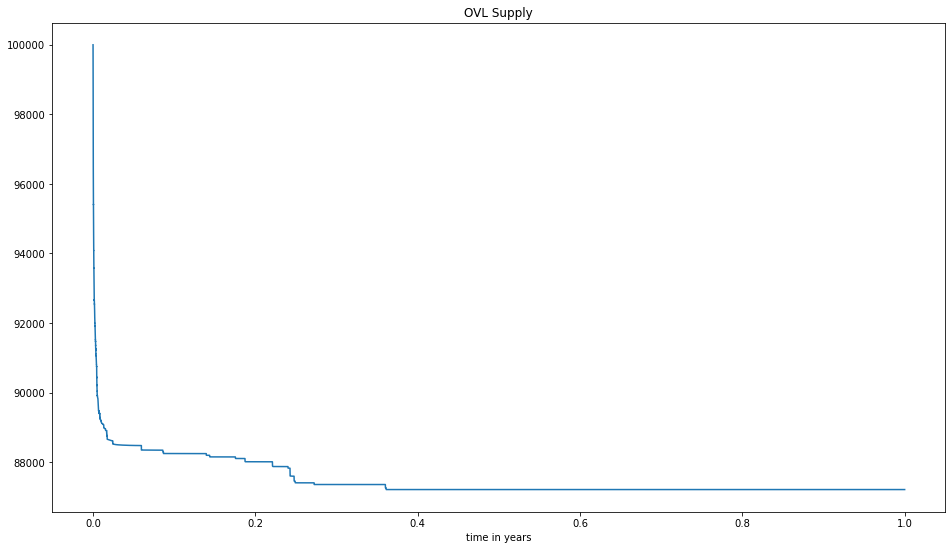

In [70]:
plot_supply(model_vars_df=model_vars_df, 
            plot_time_scale=plot_time_scale, 
            time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
            time_resolution=time_resolution, 
            data_interval=data_collection_options.data_collection_interval)

### Liquidity

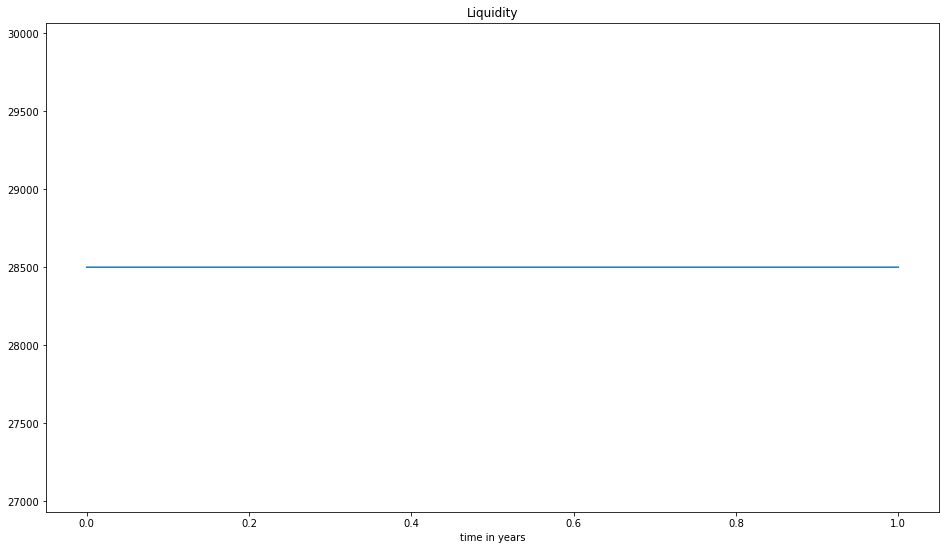

In [71]:
plot_liquidity(model_vars_df=model_vars_df,  
               plot_time_scale=plot_time_scale, 
               time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
               time_resolution=time_resolution, 
               data_interval=data_collection_options.data_collection_interval)

### Treasury

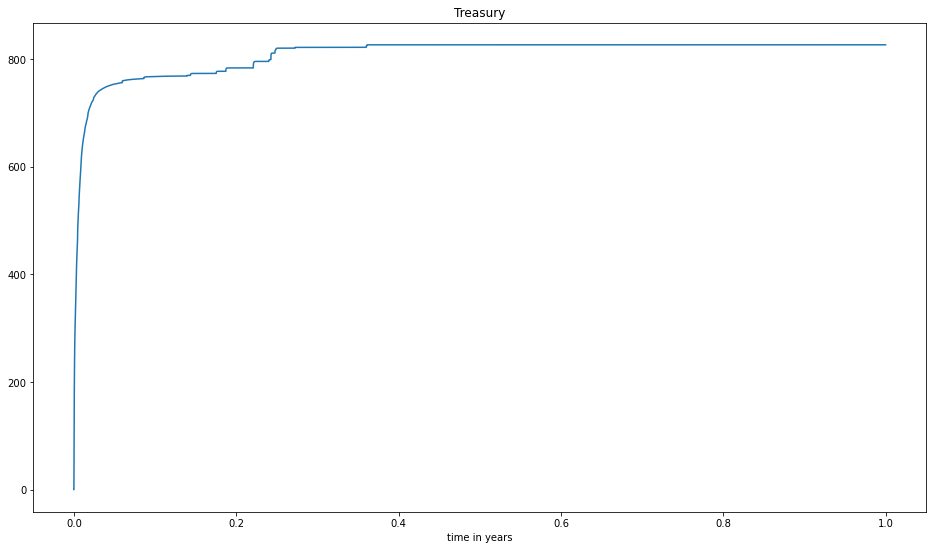

In [72]:
plot_treasury(model_vars_df=model_vars_df, 
              plot_time_scale=plot_time_scale, 
              time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
              time_resolution=time_resolution, 
              data_interval=data_collection_options.data_collection_interval)

### Price Deviations

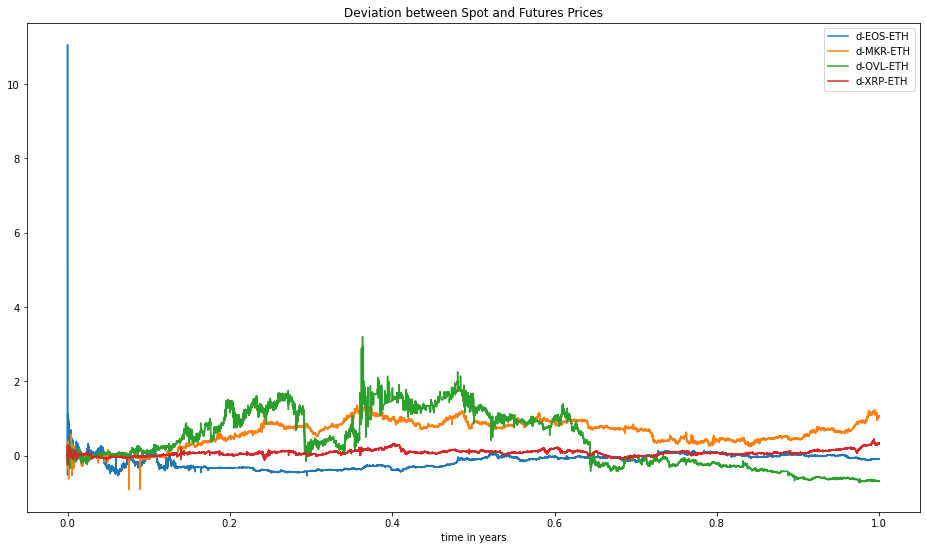

In [73]:
plot_price_deviations(
    model_vars_df=model_vars_df, 
    tickers=tickers_with_ovl, 
    plot_time_scale=plot_time_scale, 
    time_resolution=time_resolution, 
    time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
    data_interval=data_collection_options.data_collection_interval)

### Open Positions

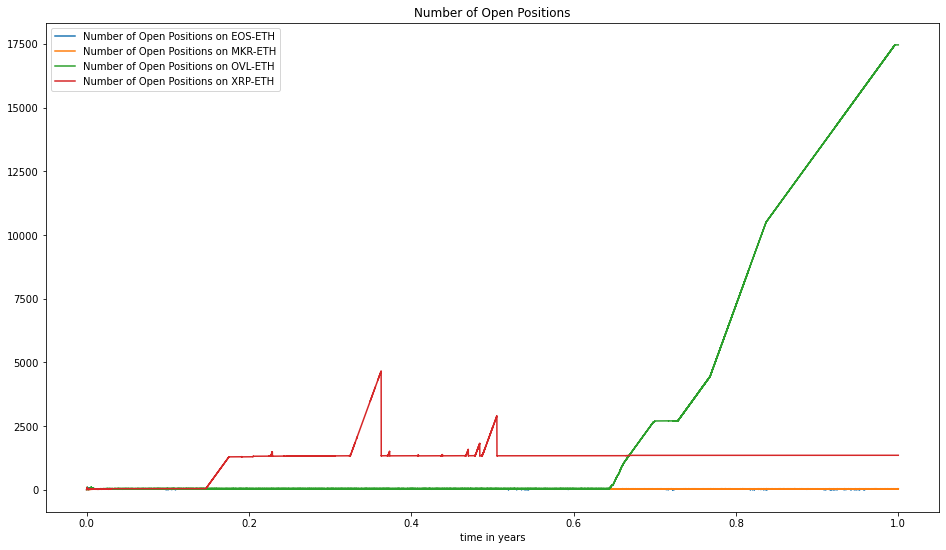

In [74]:
plot_open_positions(
    model_vars_df=model_vars_df, 
    tickers=tickers_with_ovl, 
    plot_time_scale=plot_time_scale, 
    time_resolution=time_resolution, 
    time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
    data_interval=data_collection_options.data_collection_interval)

### Skew

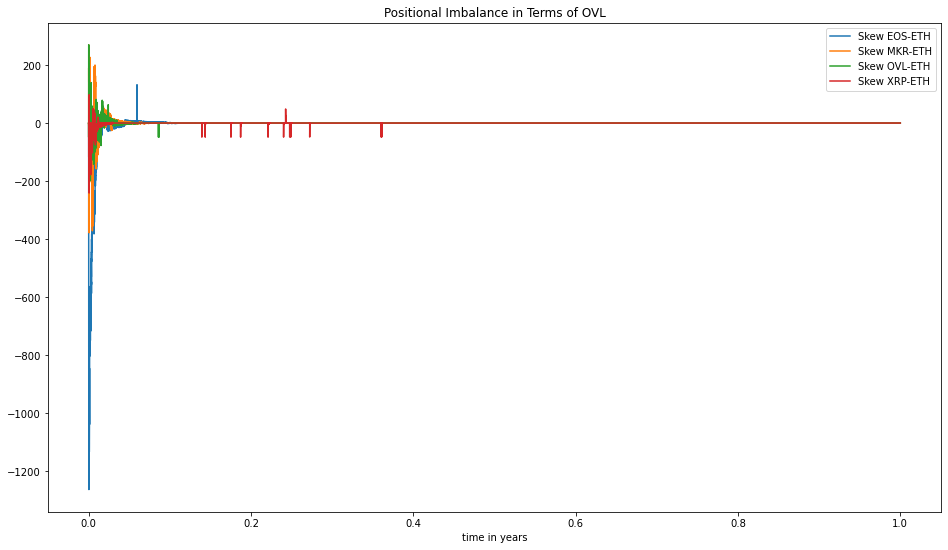

In [75]:
plot_skews(
    model_vars_df=model_vars_df, 
#     tickers=tickers_with_ovl[1:], 
    tickers=tickers_with_ovl, 
    plot_time_scale=plot_time_scale, 
    time_resolution=time_resolution, 
    time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
    data_interval=data_collection_options.data_collection_interval)

#### Correlation between Skew and Futures Price

In [76]:
for i, ticker in enumerate(tickers_with_ovl):
    if i > 0:
        break
    skew = model_vars_df.loc[:, skew_label(ticker)].values
    futures_price = model_vars_df.loc[:, futures_price_label(ticker)].values
    spot_price = model_vars_df.loc[:, spot_price_label(ticker)].values
    print(np.corrcoef(skew, futures_price))
    print(np.corrcoef(skew, spot_price))

[[1.        0.2913045]
 [0.2913045 1.       ]]
[[1.         0.19196379]
 [0.19196379 1.        ]]


### Cumulative Returns

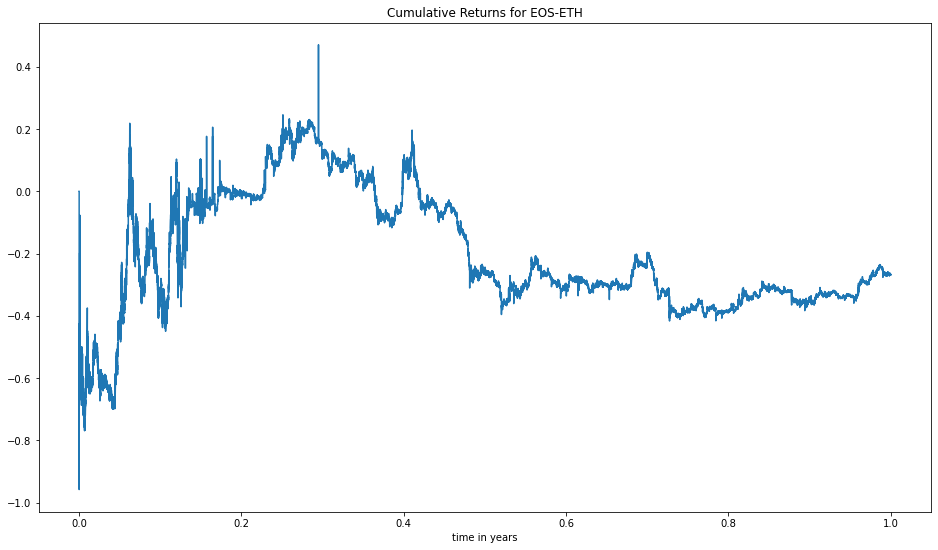

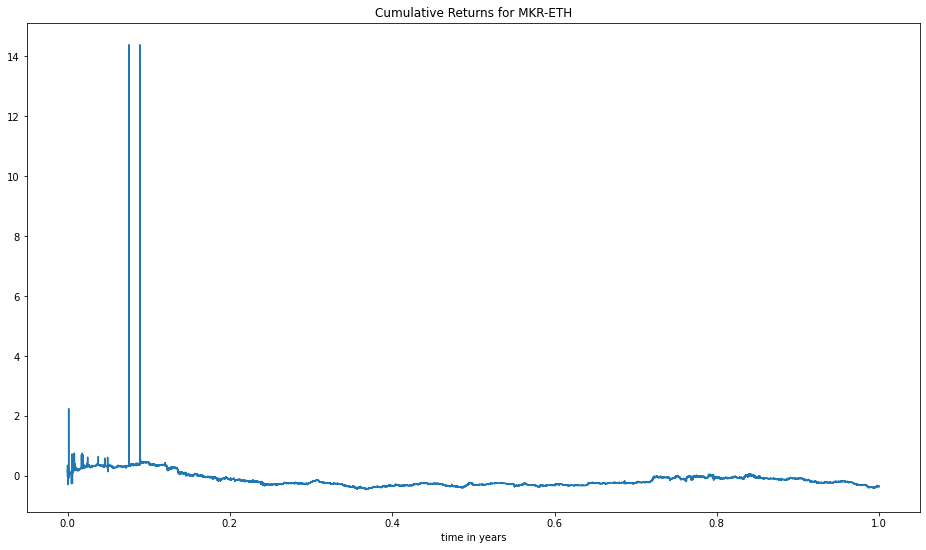

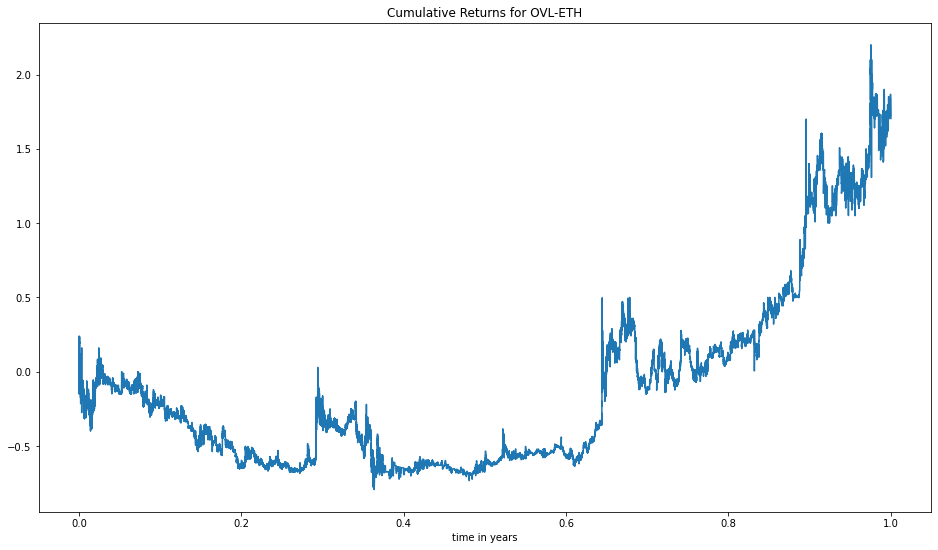

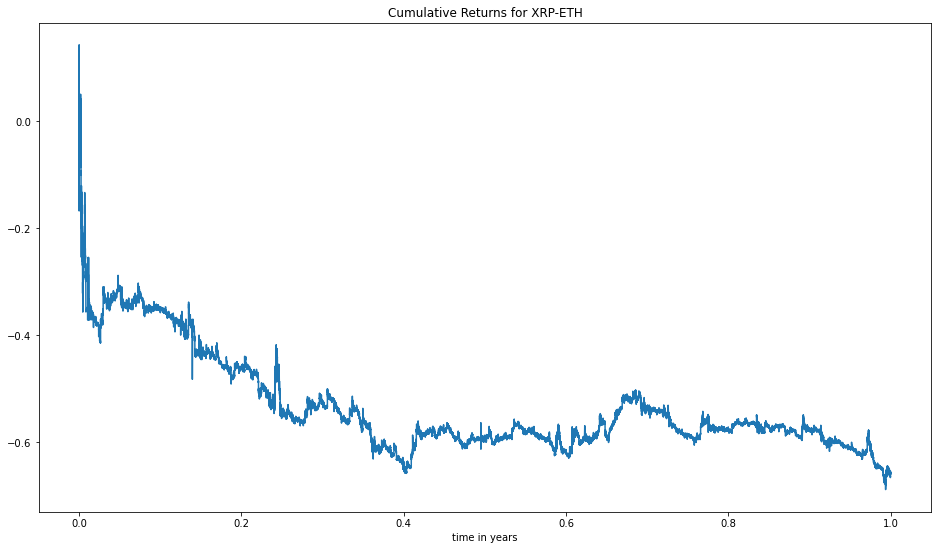

In [77]:
for i, ticker in enumerate(tickers_with_ovl):
    spot_prices_for_ticker = model_vars_df.loc[:, spot_price_label(ticker)].values
    cumulative_return_for_ticker = spot_prices_for_ticker / spot_prices_for_ticker[0] - 1.0
    
    plot_single_variable_over_time_from_numpy_array(
        array=cumulative_return_for_ticker, 
        plot_time_scale=plot_time_scale, 
        time_resolution=time_resolution, 
        time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
        data_interval=data_collection_options.data_collection_interval)
    
    plt.title(f'Cumulative Returns for {ticker}')

### Spot vs. Futures Prices

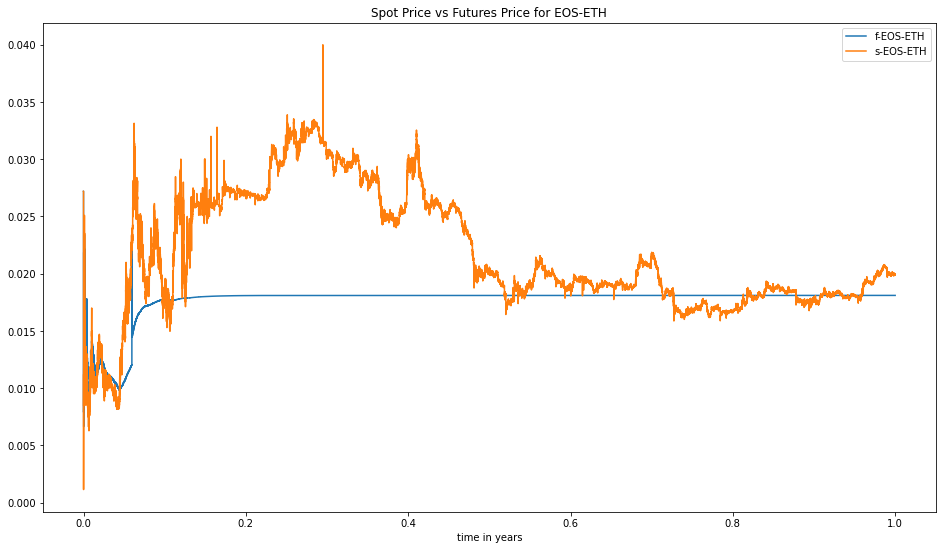

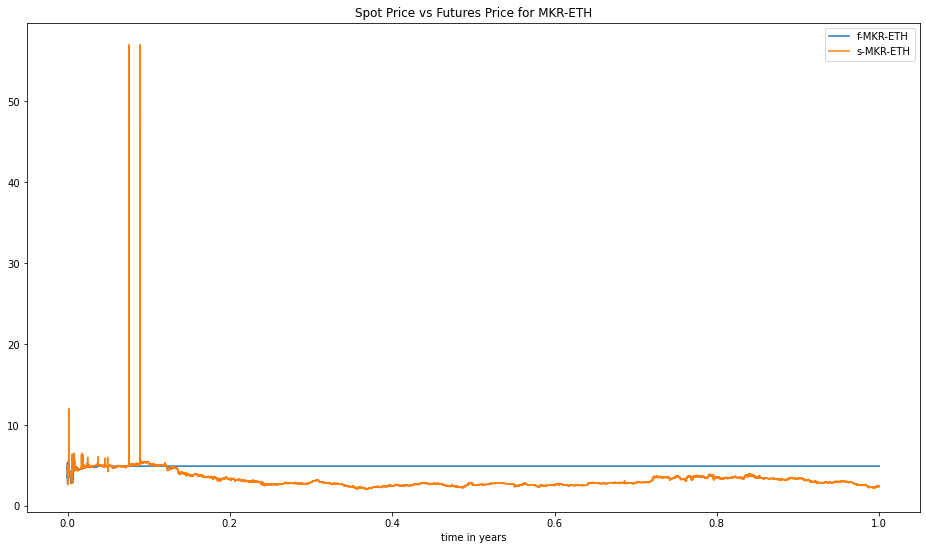

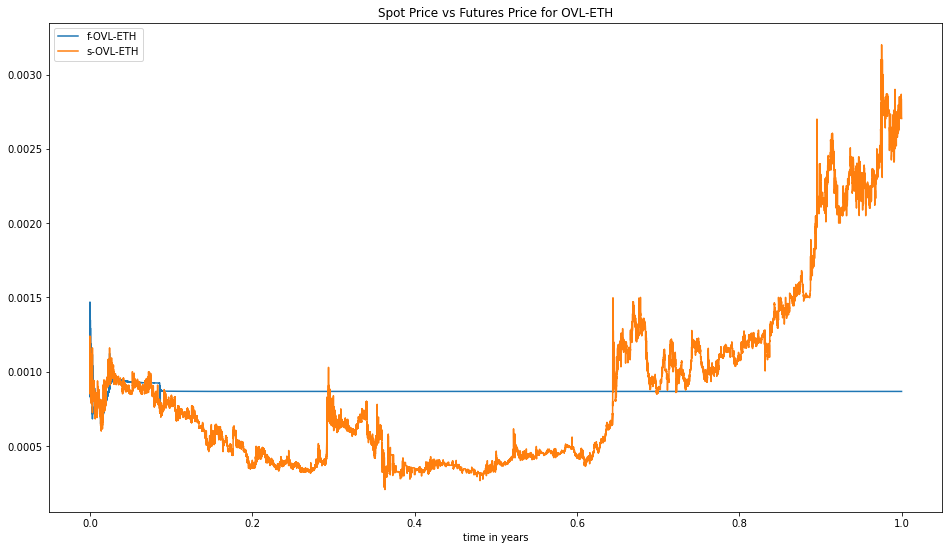

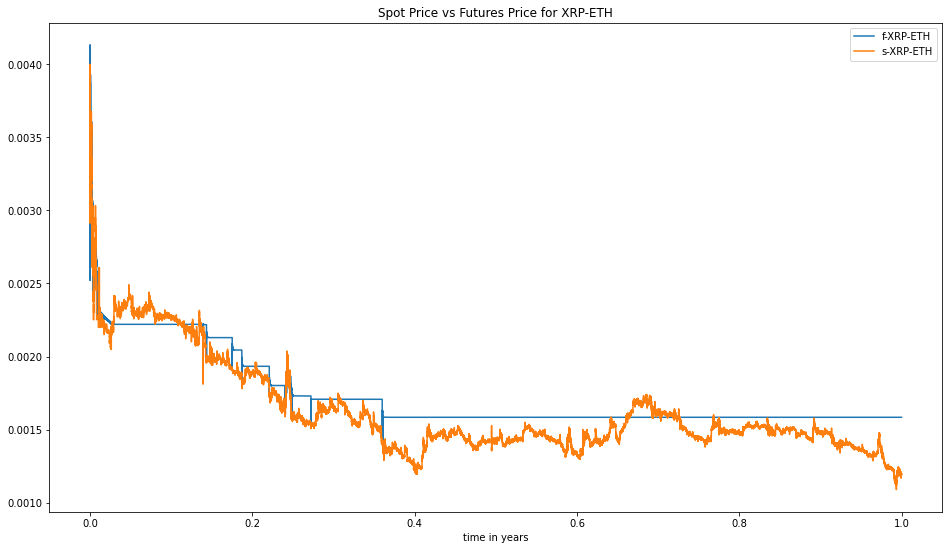

In [78]:
for i, ticker in enumerate(tickers_with_ovl):
    plot_spot_vs_futures_price(
        model_vars_df=model_vars_df, 
        ticker=ticker, 
        plot_time_scale=plot_time_scale, 
        time_resolution=time_resolution, 
        time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
        data_interval=data_collection_options.data_collection_interval)

In [79]:
# model_vars_df.columns

In [80]:
# tickers_with_ovl[0]

In [81]:
# def plot_cumulative_spot_returns(
#         model_vars_df: pd.DataFrame,
#         ticker: str,
#         plot_time_scale: TimeScale,
#         time_resolution: TimeResolution,
#         time_interval_to_plot_in_seconds:
#         tp.Optional[tp.Tuple[tp.Optional[float], tp.Optional[float]]] = None,
#         figure_size: tp.Tuple[float, float] = DEFAULT_FIGURE_SIZE,
#         data_interval: int = 1,
#         # relative: bool = False
# ):
#     column_name_to_label_map = \
#         {spot_price_label(ticker): spot_price_label(ticker)}

#     plot_multiple_variables_over_time(
#         model_vars_df=model_vars_df,
#         column_name_to_label_map=column_name_to_label_map,
#         plot_time_scale=plot_time_scale,
#         time_resolution=time_resolution,
#         time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds,
#         figure_size=figure_size,
#         data_interval=data_interval)

#     plt.legend();
#     plt.title(f'Spot Price vs Futures Price for {ticker}')


In [82]:
# %lprun \
#     -f compute_gini \
#     -f compute_price_difference \
#     -f compute_futures_price \
#     -f compute_spot_price \
#     -f compute_supply \
#     -f compute_liquidity \
#     -f compute_treasury \
#     -f compute_wealth_for_agent_type \
#     -f compute_inventory_wealth_for_agent \
#     -f compute_inventory_wealth_for_agent_type \
#     -f compute_positional_imbalance_by_market \
#     -f DataCollector.collect \
#     -f MonetaryAgent.step \
#     -f MonetaryArbitrageur._unwind_positions \
#     -f MonetaryArbitrageur._unwind_next_position \
#     -f MonetaryArbitrageur.trade \
#     -f MonetaryArbitrageur.step \
#     -f MonetaryKeeper.step \
#     -f MonetaryKeeper.distribute_funding \
#     -f MonetaryLiquidator.scope_liquidations \
#     -f MonetaryLiquidator.step \
#     -f MonetarySniper._get_unwind_amount \
#     -f MonetarySniper._unwind_positions \
#     -f MonetarySniper._get_filled_price \
#     -f MonetarySniper._get_size \
#     -f MonetarySniper._get_effective_edge \
#     -f MonetarySniper.trade \
#     -f MonetaryFMarket.build \
#     -f MonetaryFMarket.unwind \
#     -f MonetaryFMarket._swap \
#     -f MonetaryFMarket.slippage \
#     -f MonetaryFMarket.fund \
#     -f MonetaryFMarket.funding \
#     -f MonetaryFMarket.liquidatable \
#     -f MonetaryFMarket.liquidate \
#     -f MonetaryModel.step \
#     run_model(number_of_steps_to_simulate)

In [83]:
# plt.close('all')